In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


2023-08-04 09:49:00,162	INFO worker.py:1636 -- Started a local Ray instance.


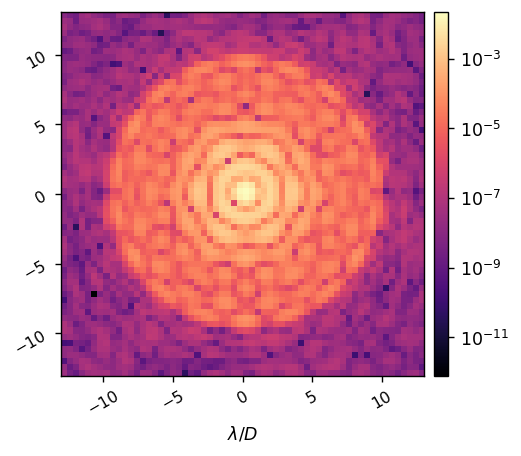

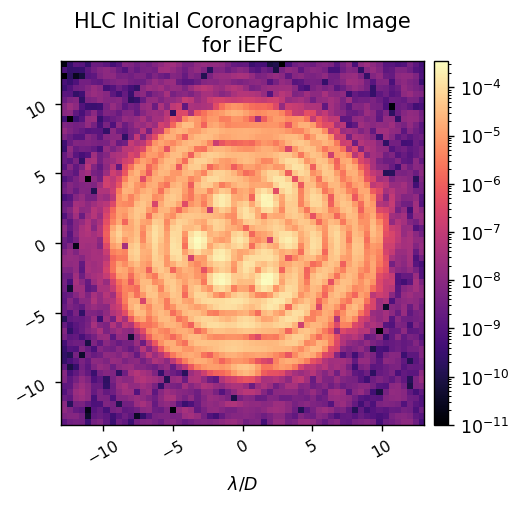

In [2]:
reload(cgi_phasec_poppy)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='hlc', npsf=60,
                                dm1_ref=dm1_flat,
                                dm2_ref=dm2_flat,
                              use_pupil_defocus=True, 
                              use_opds=True)

mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'HLC Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

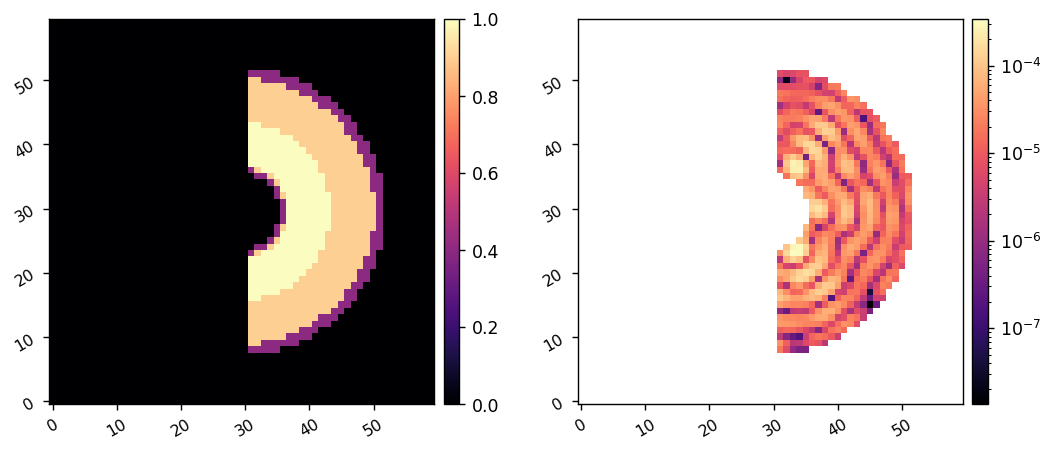

3.2067182541080806e-05


In [3]:
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=3, outer_radius=9, edge=0.5,)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=2.5, outer_radius=9.7, edge=0.5,)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=3.2, outer_radius=6, edge=0.5,)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

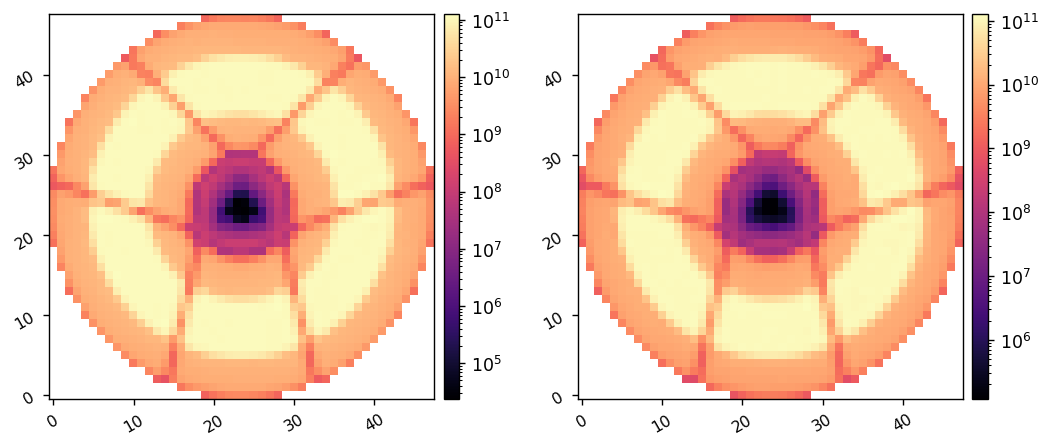

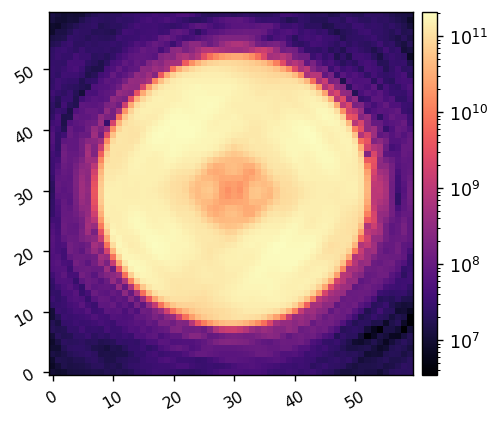

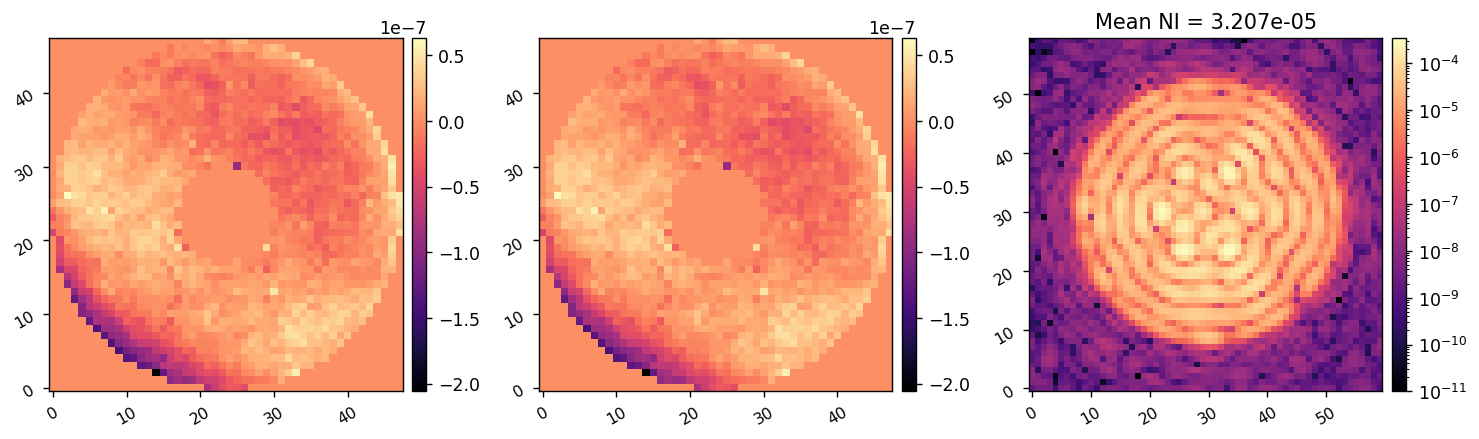

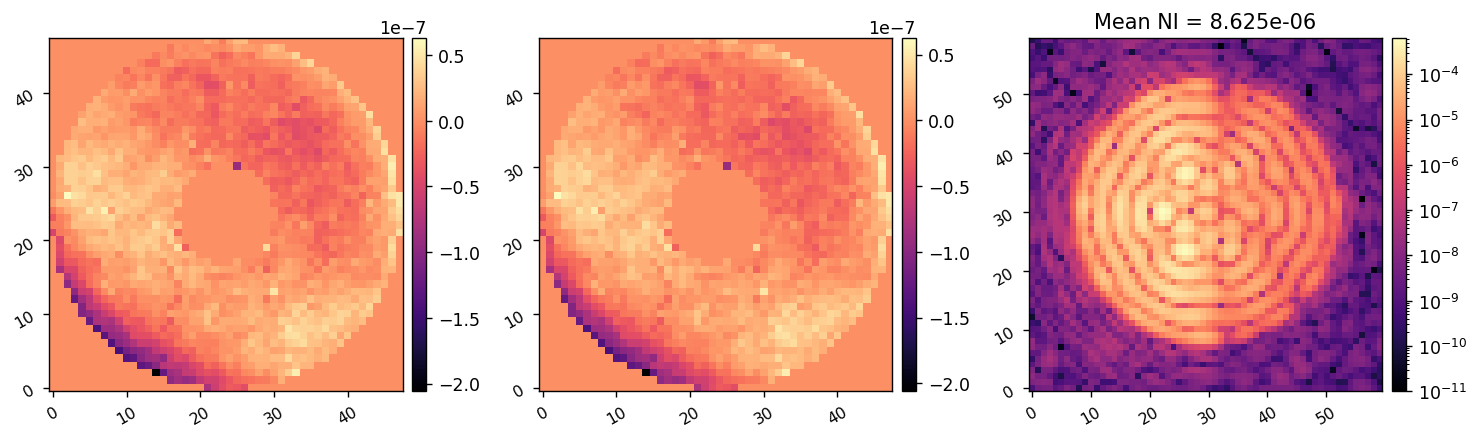

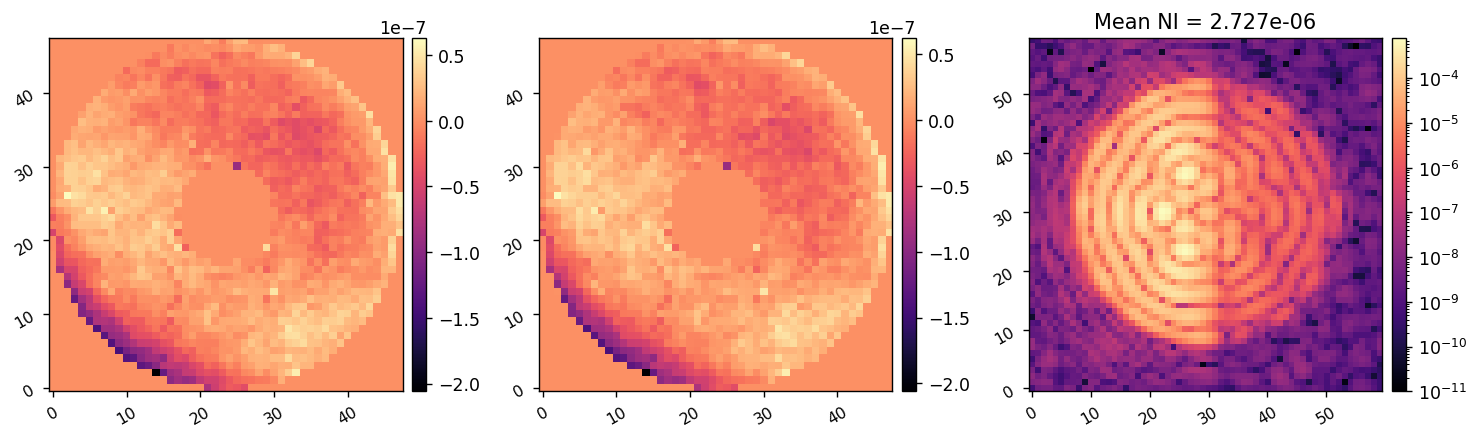

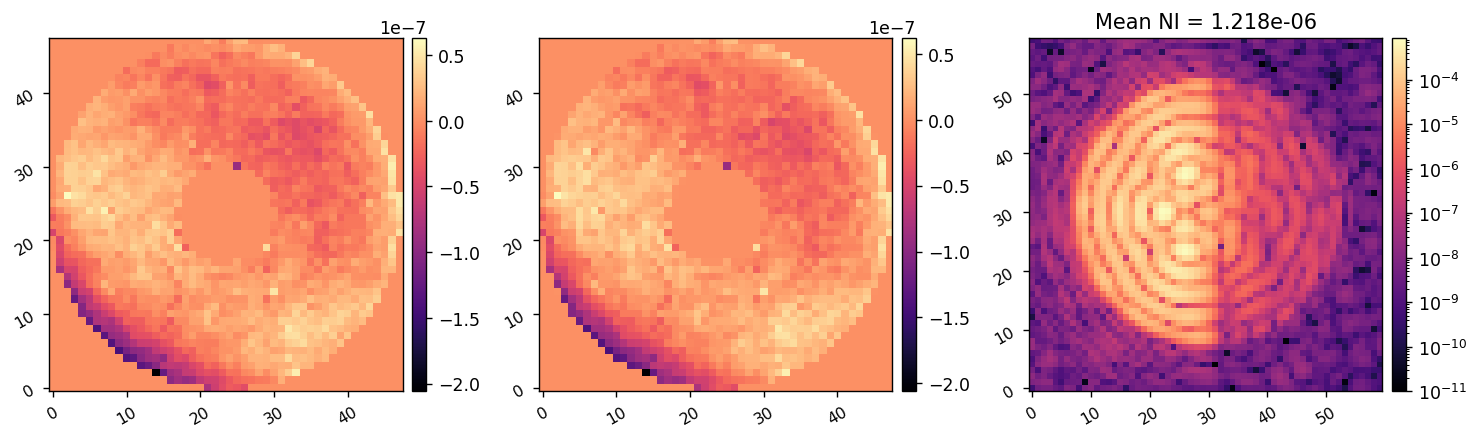

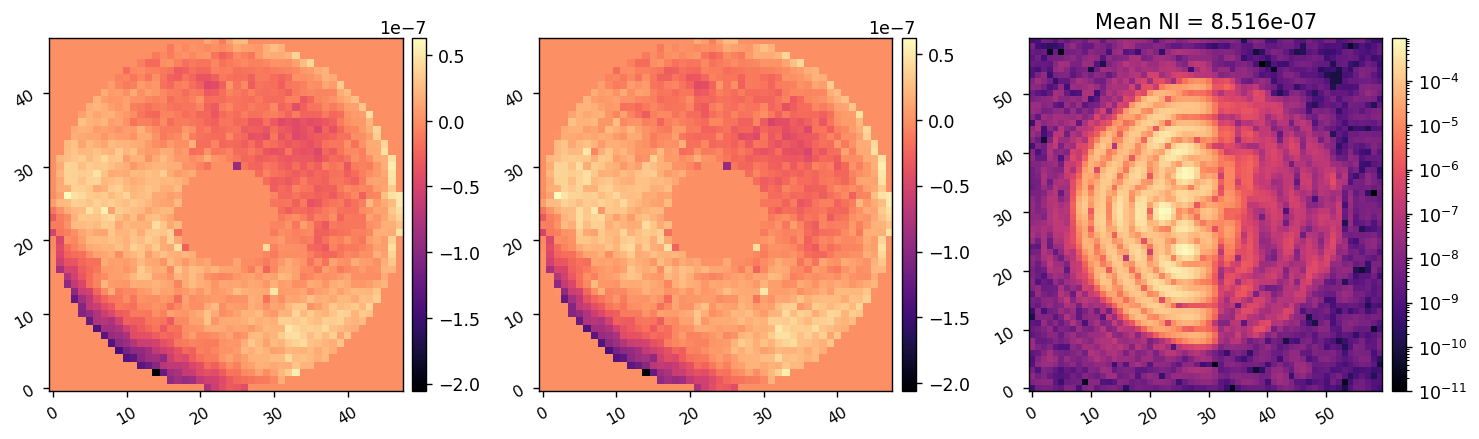

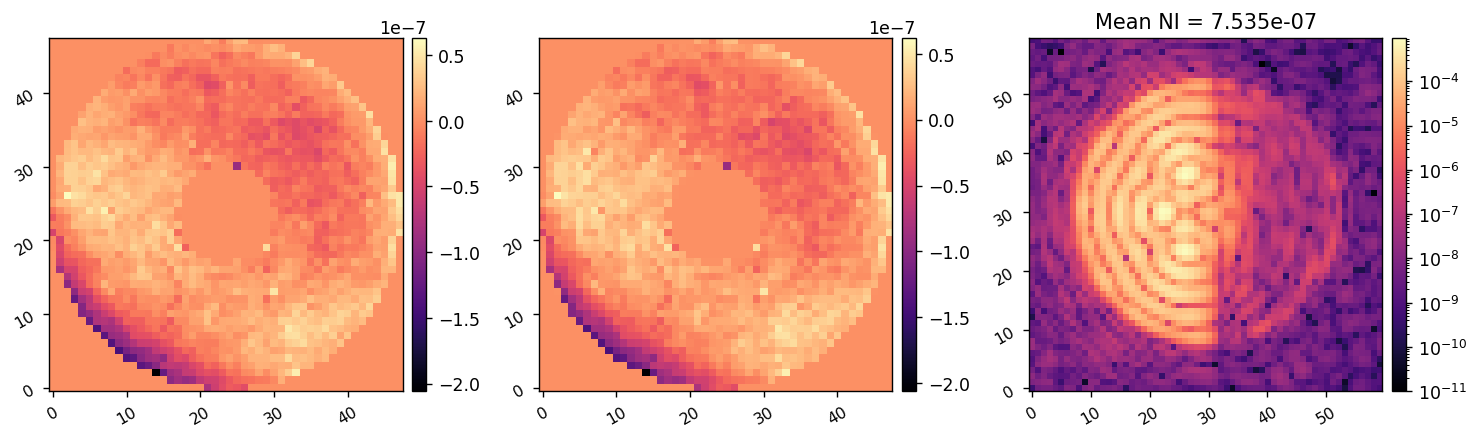

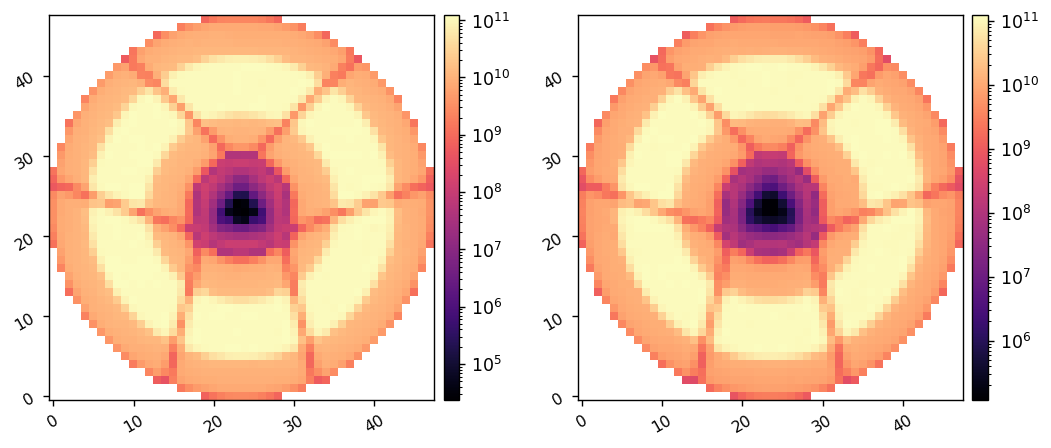

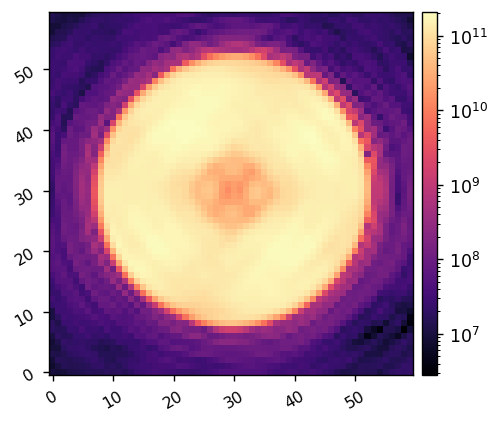

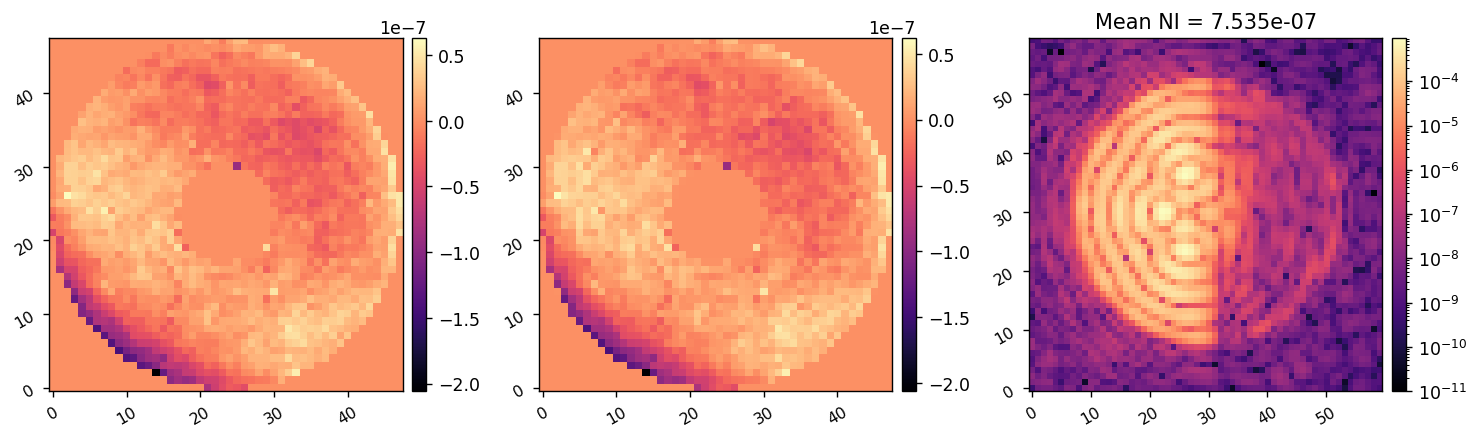

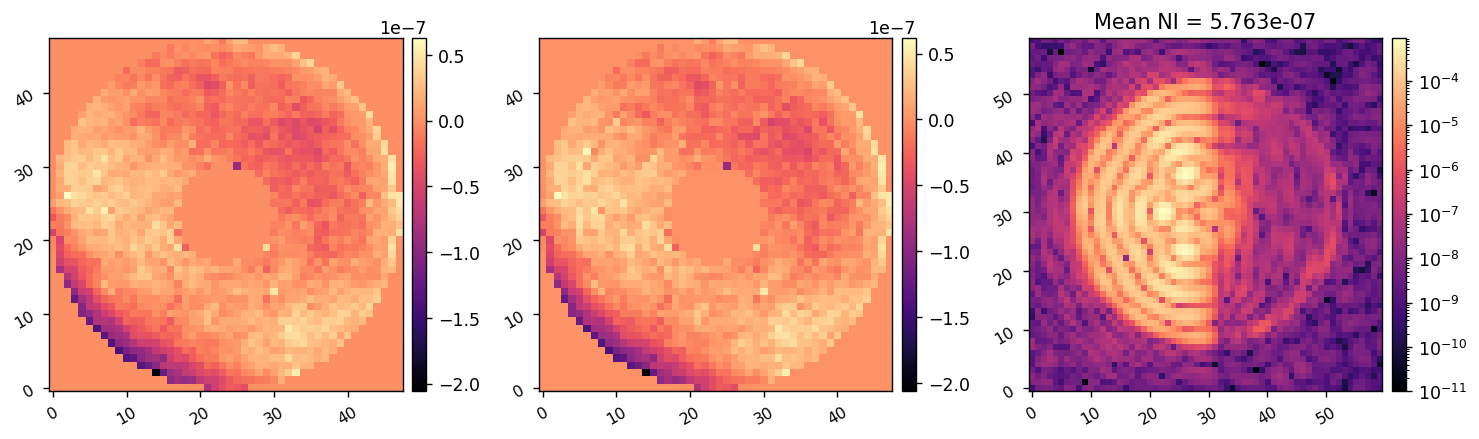

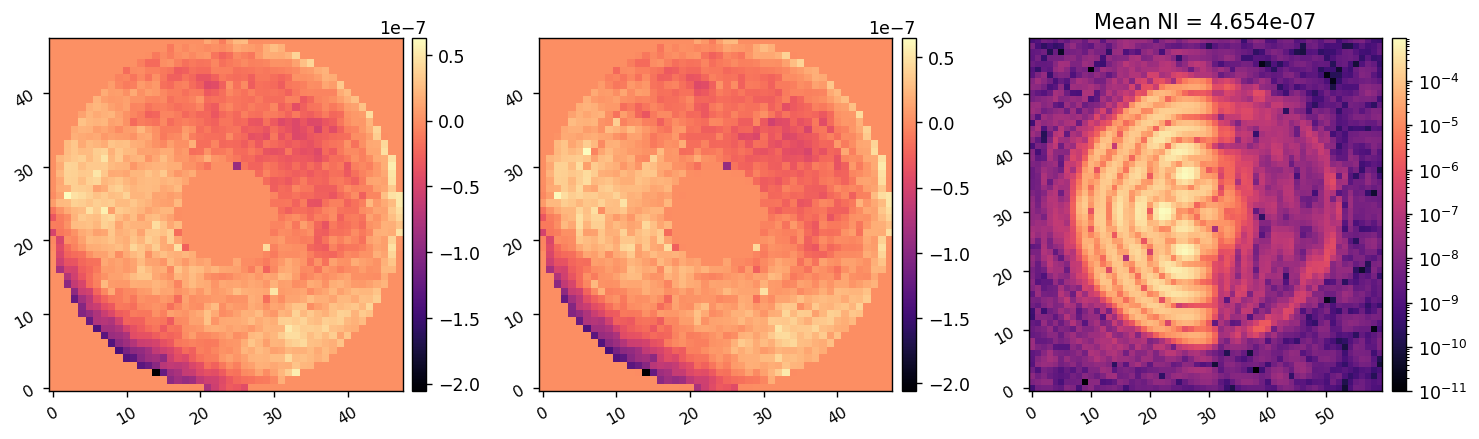

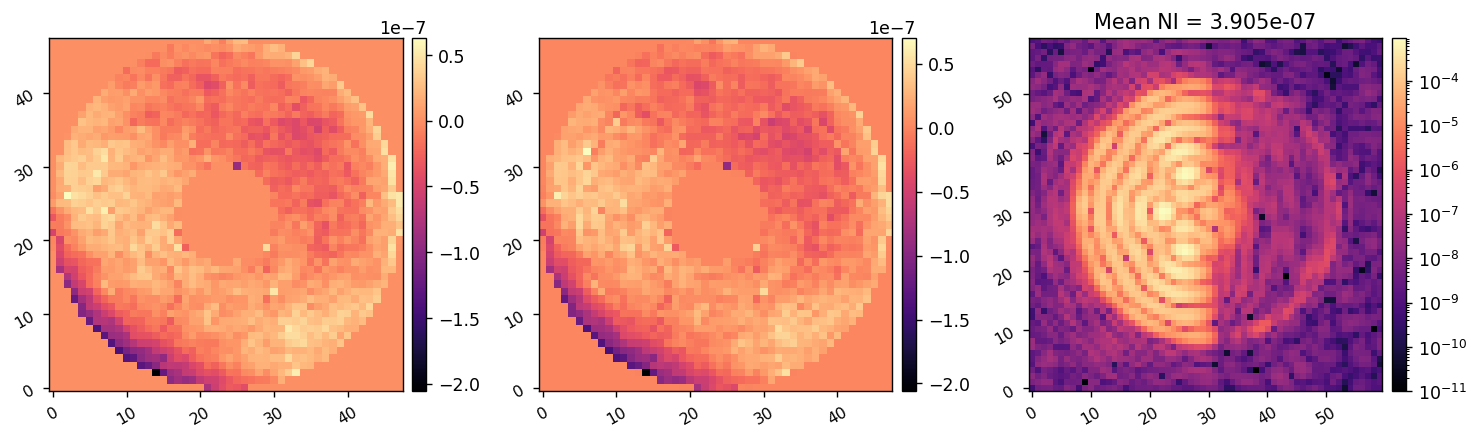

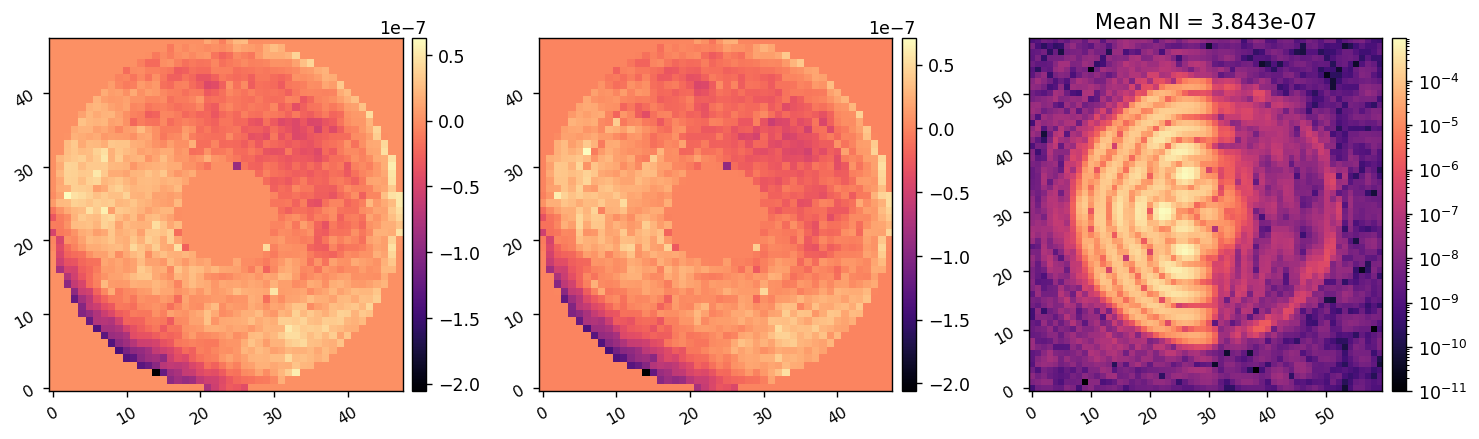

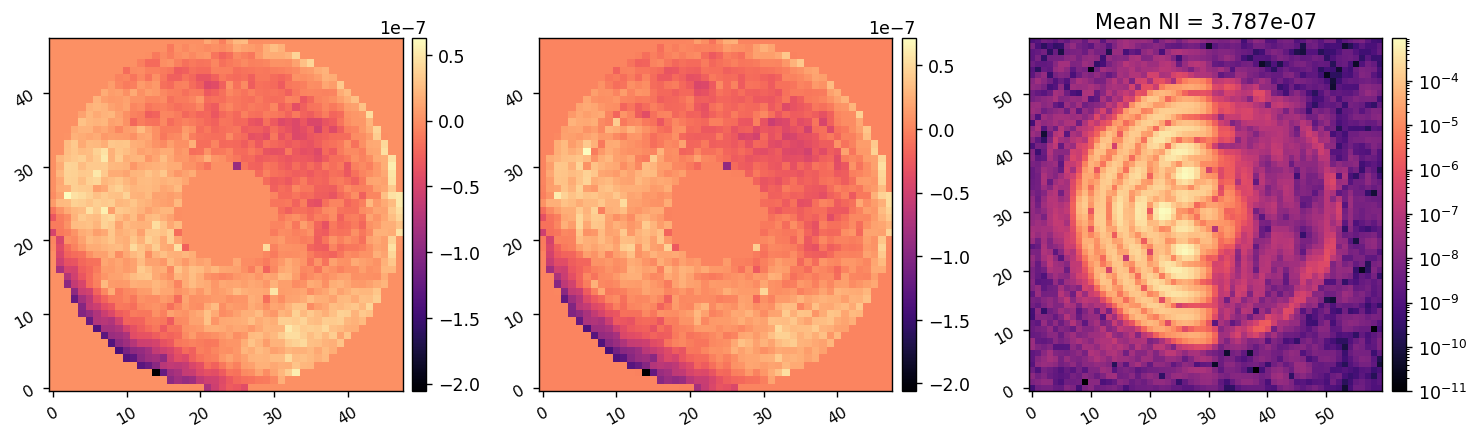

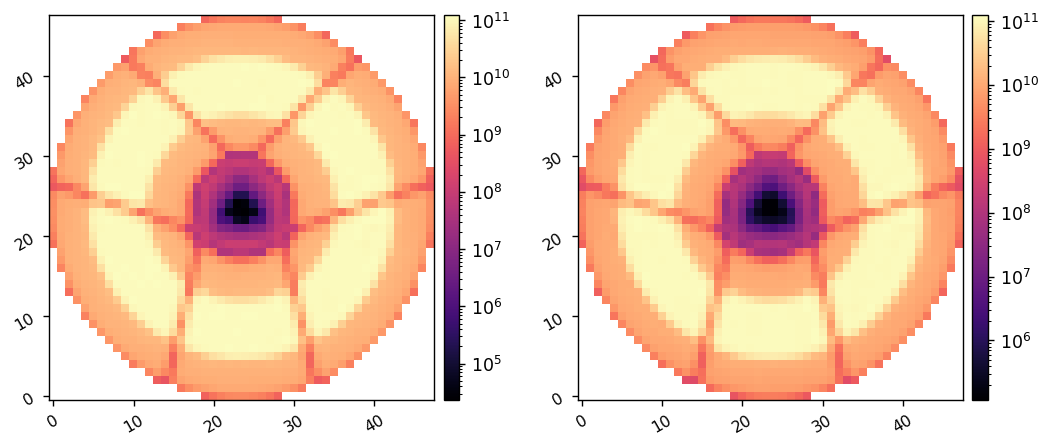

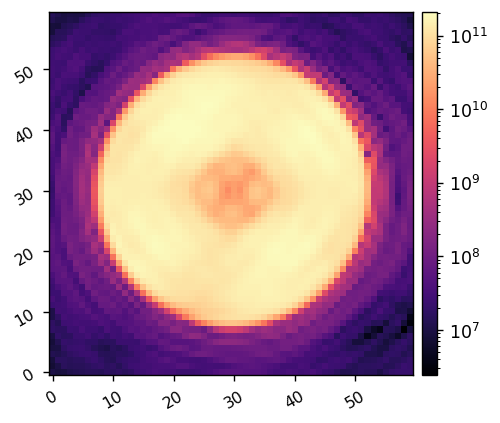

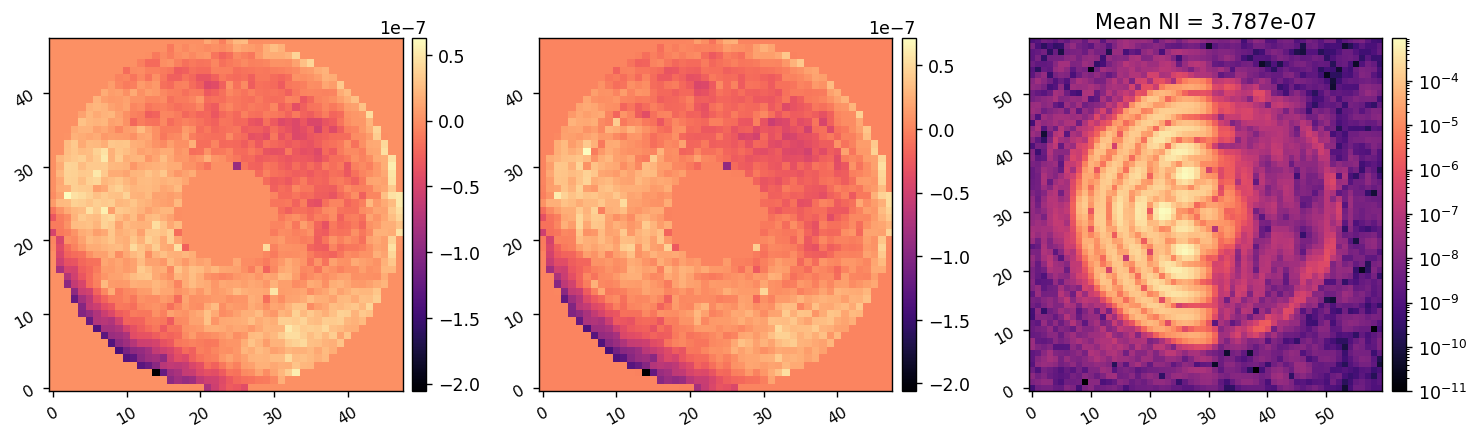

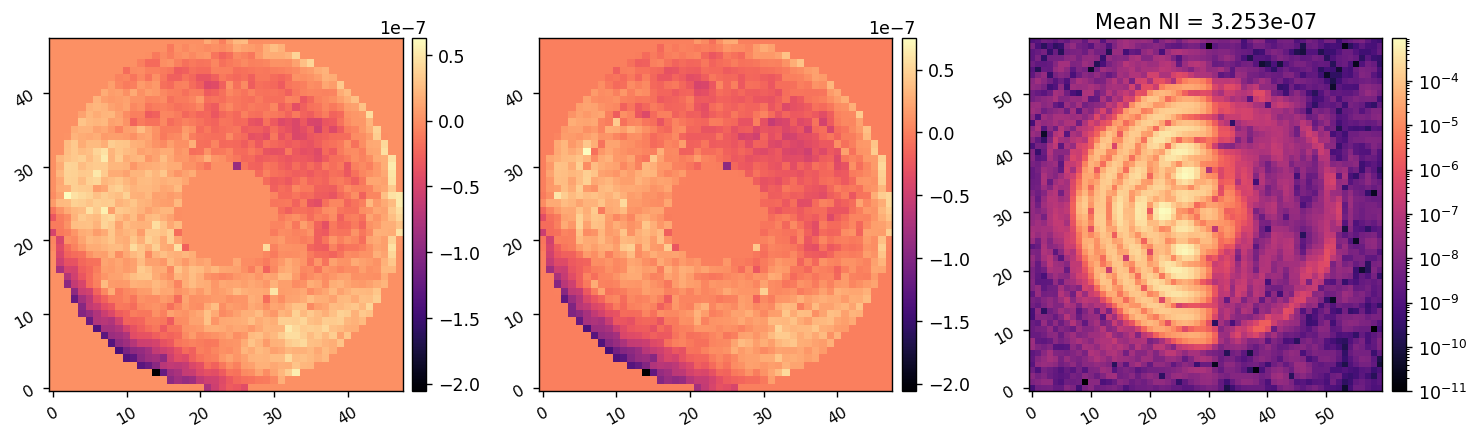

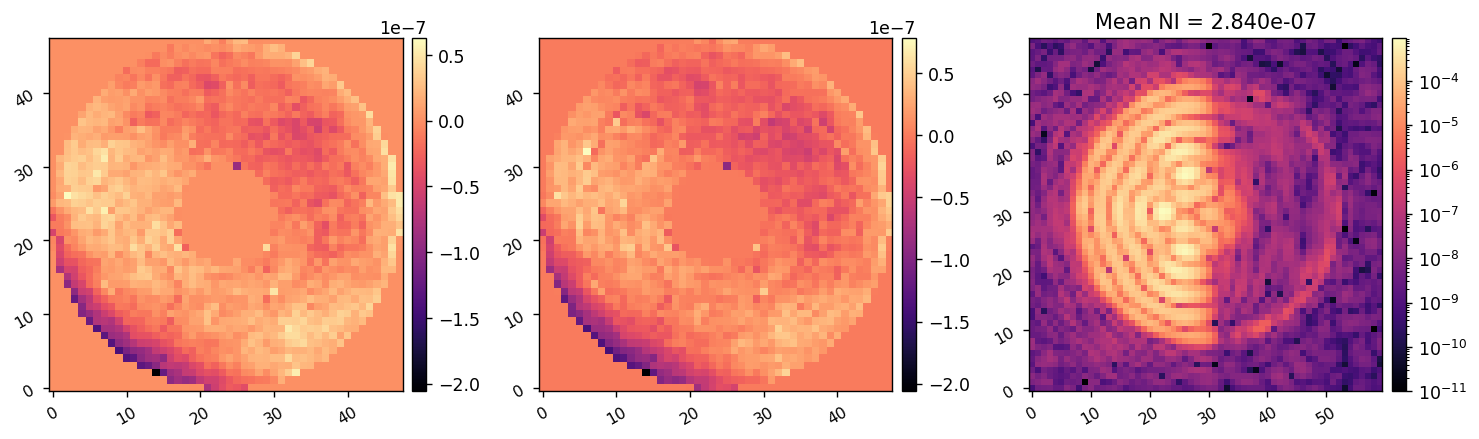

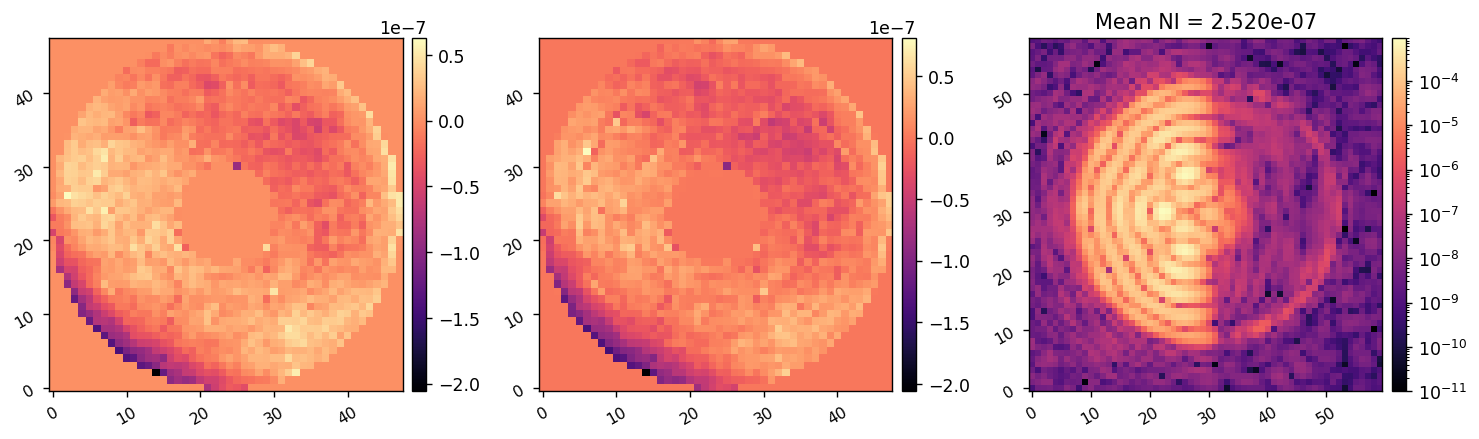

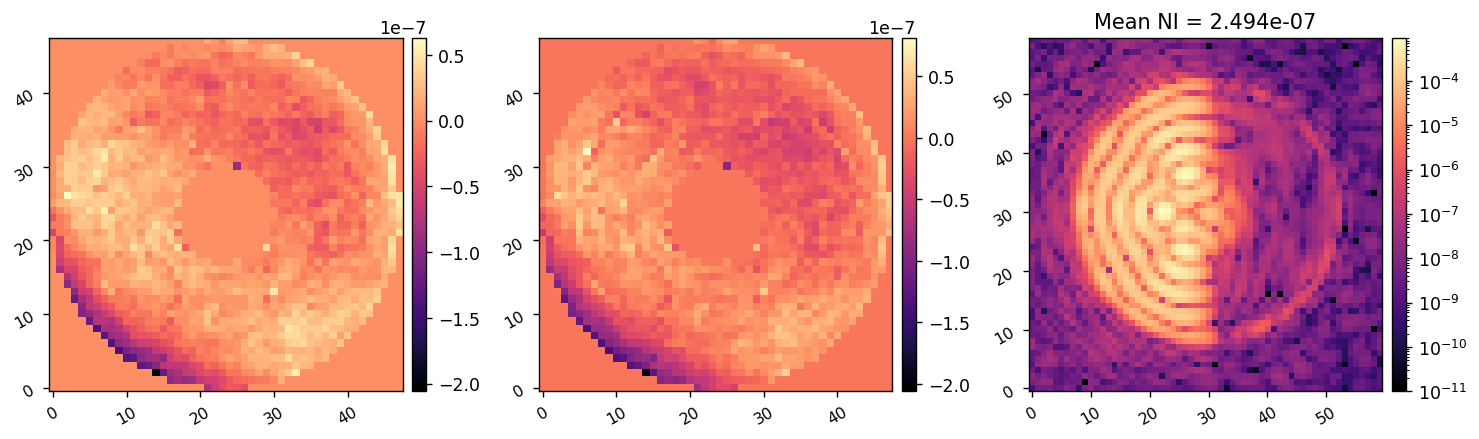

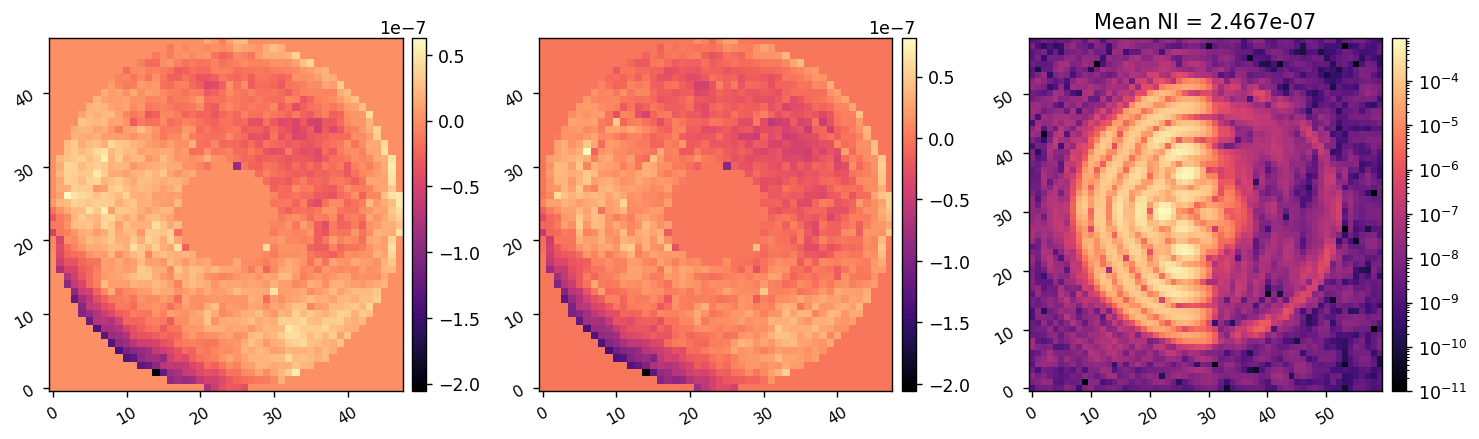

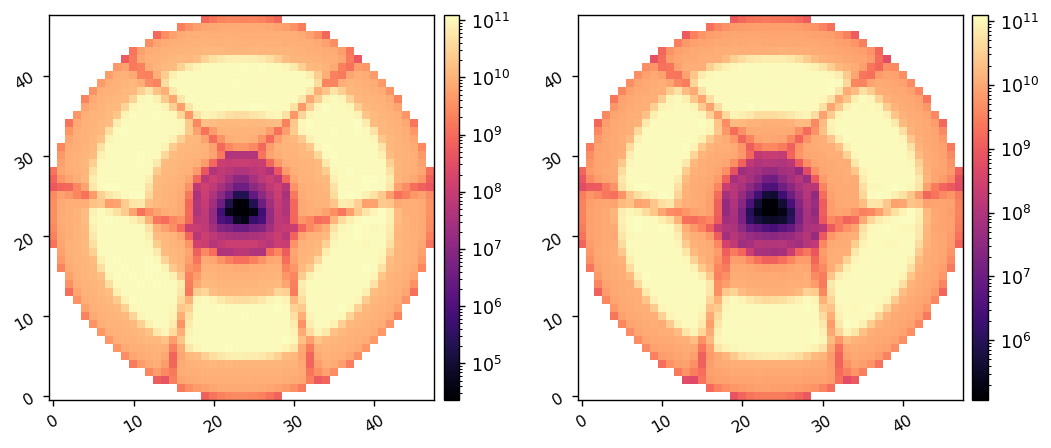

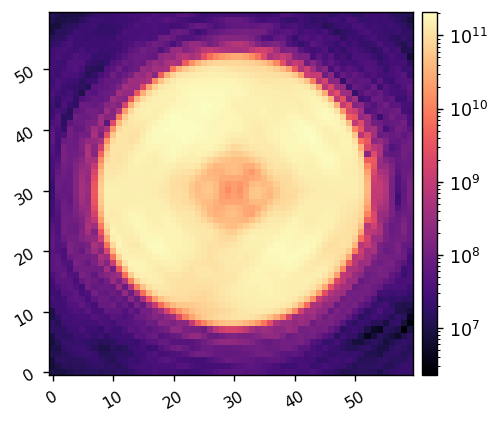

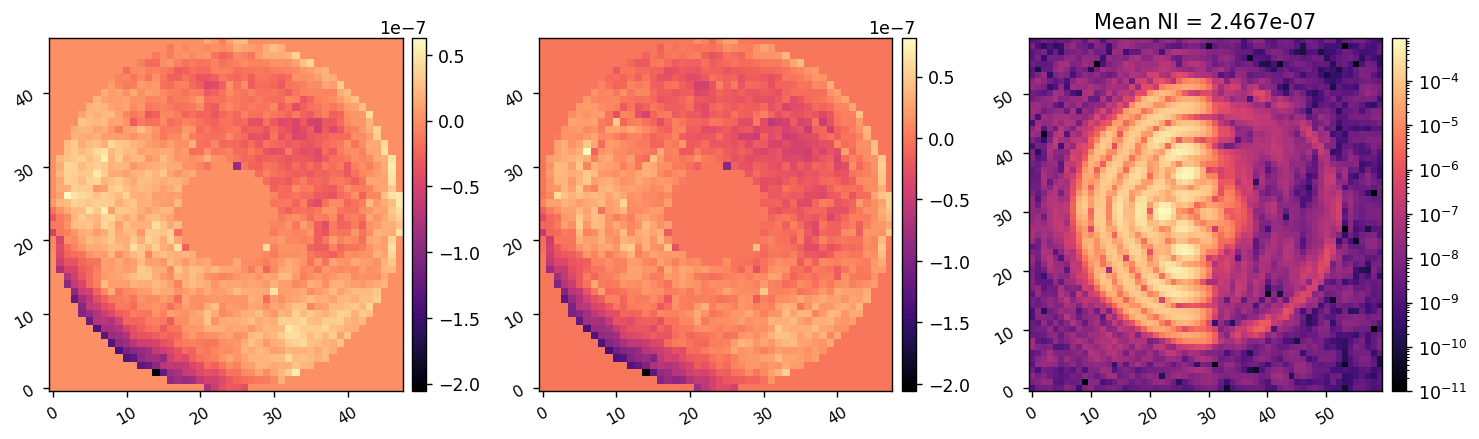

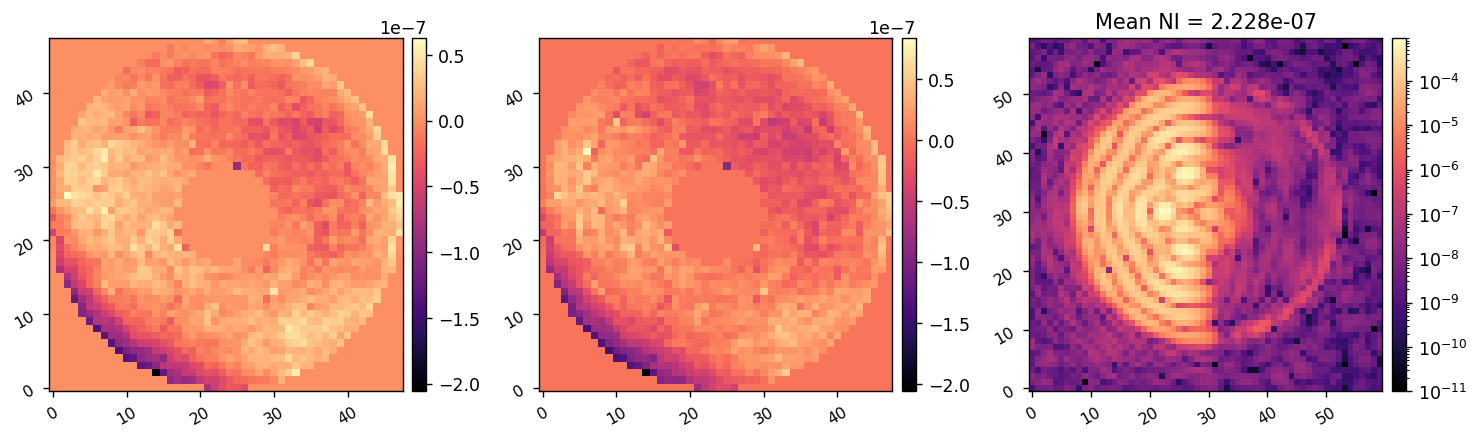

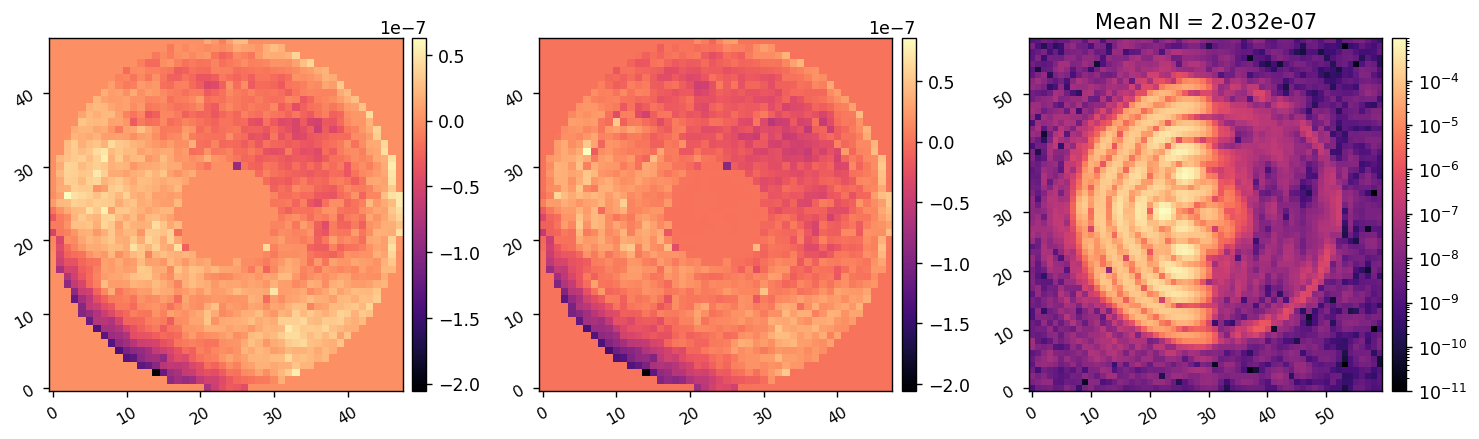

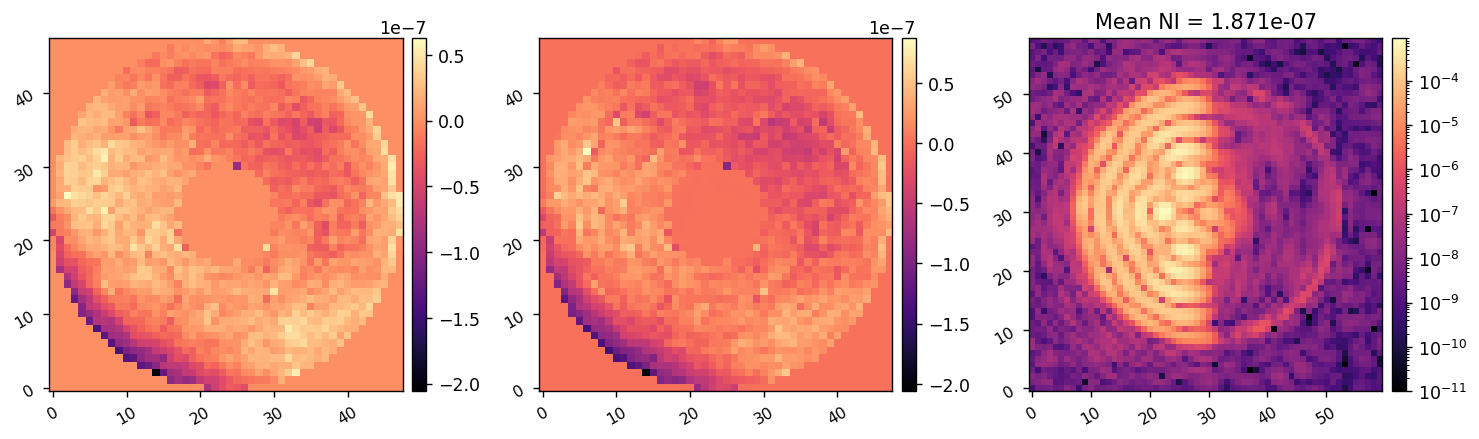

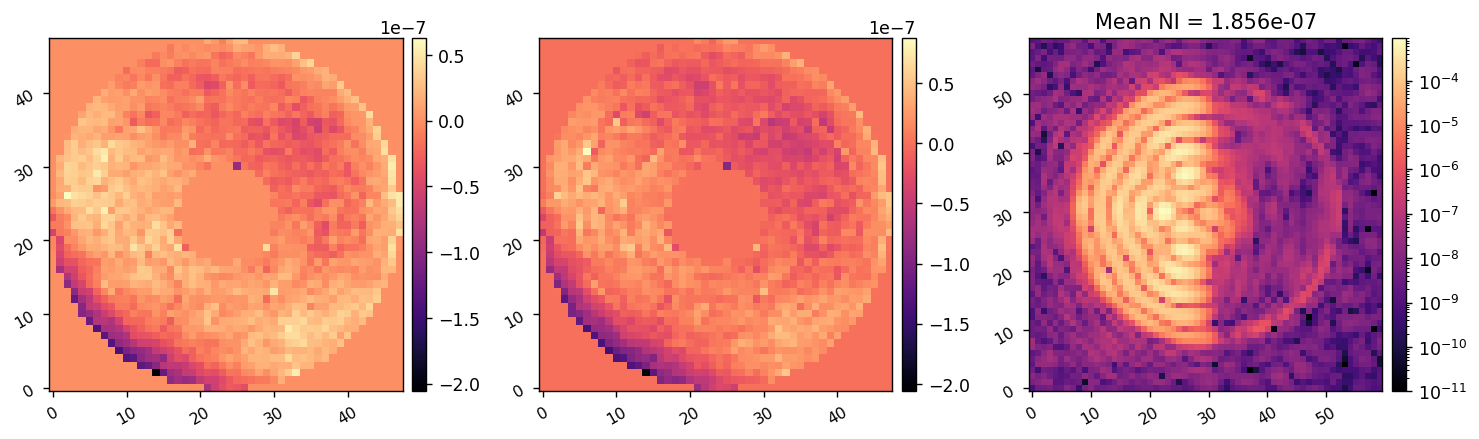

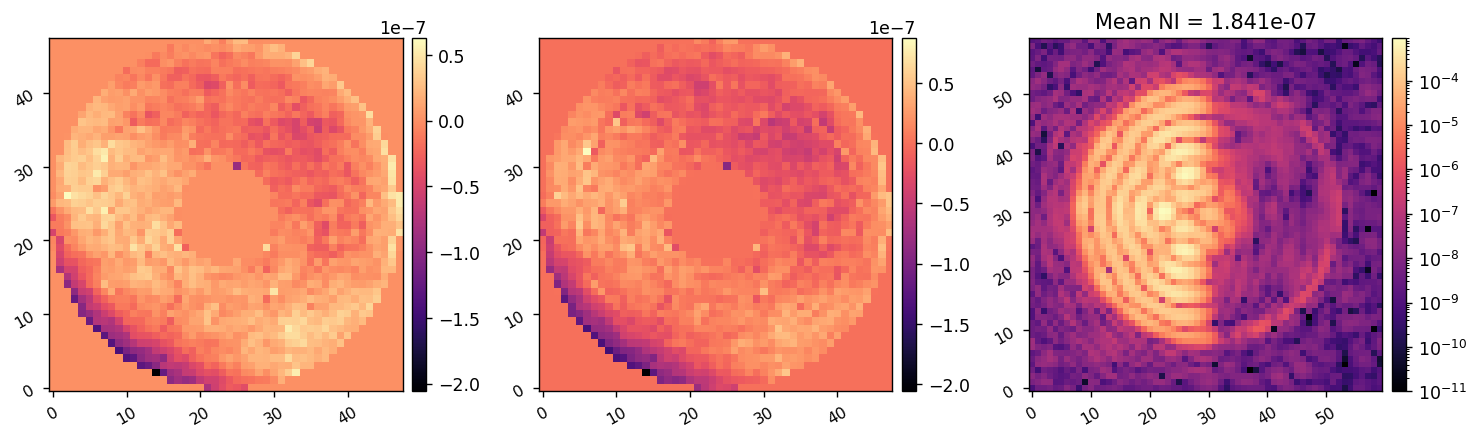

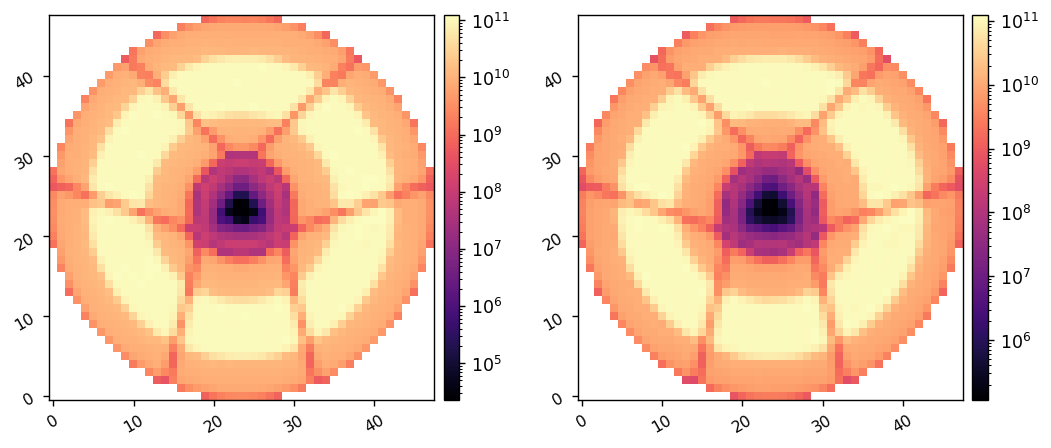

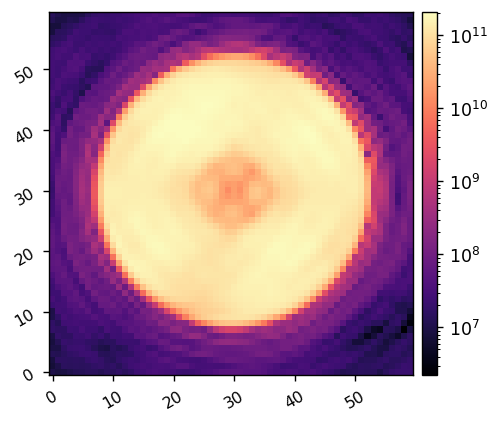

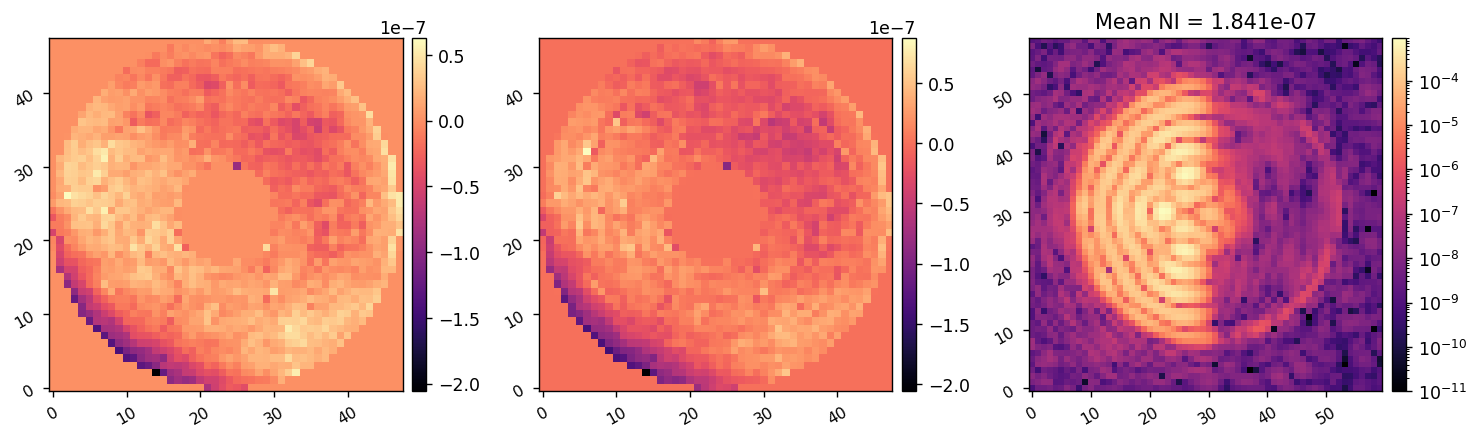

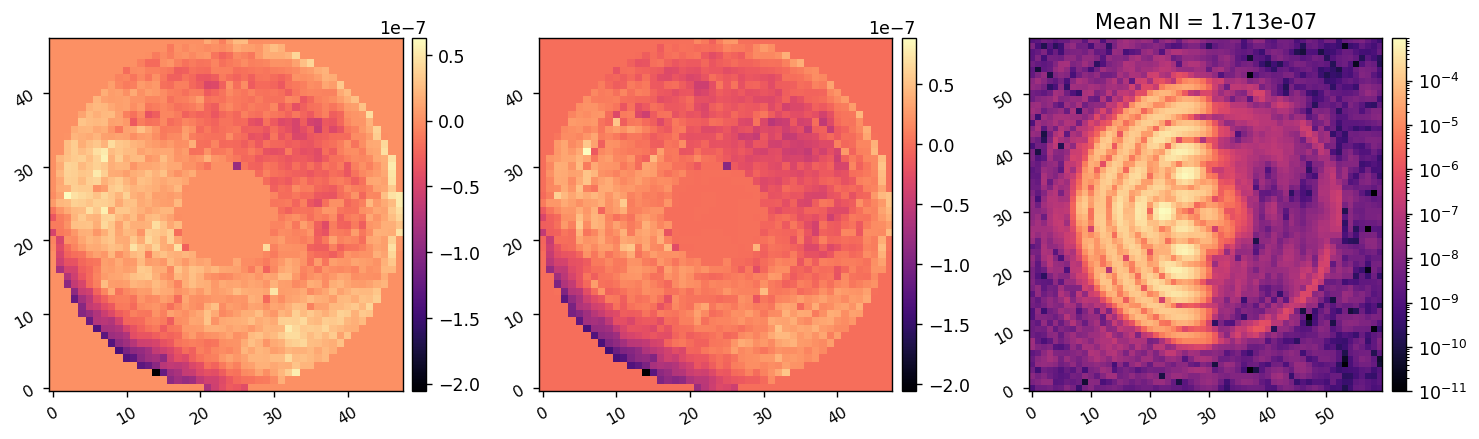

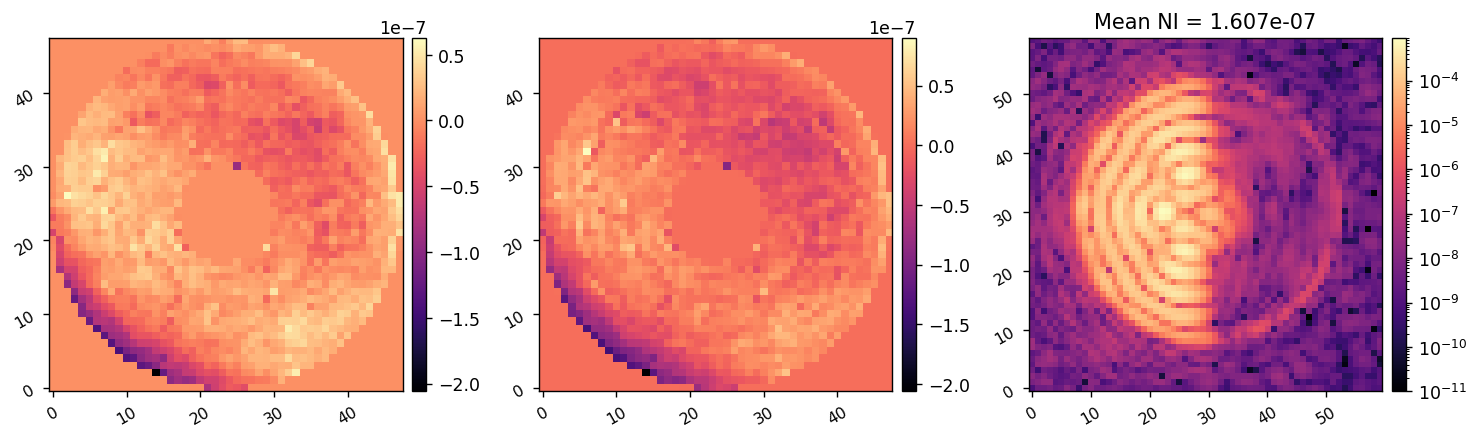

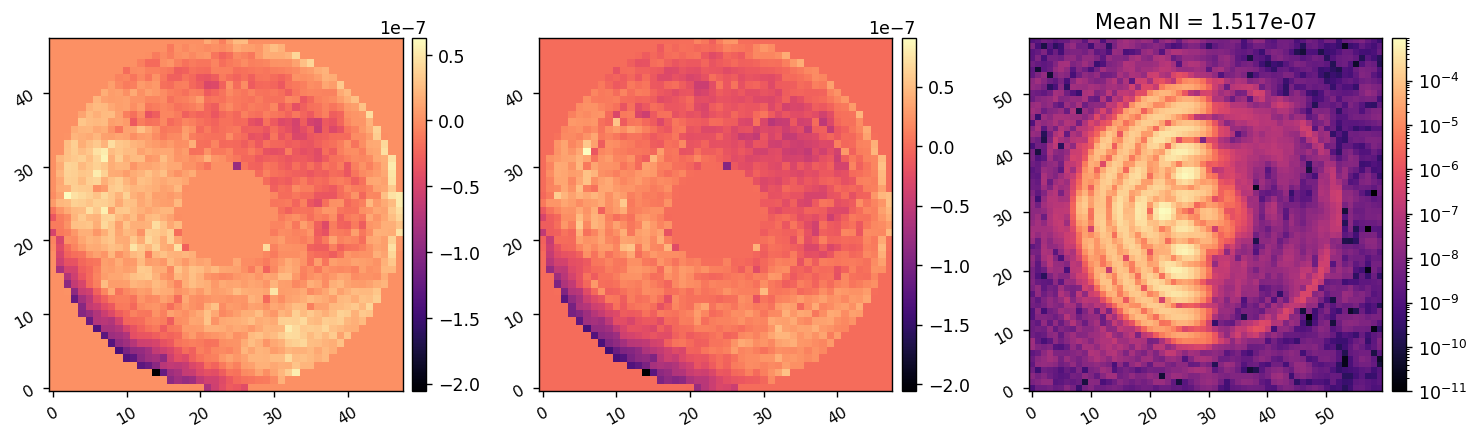

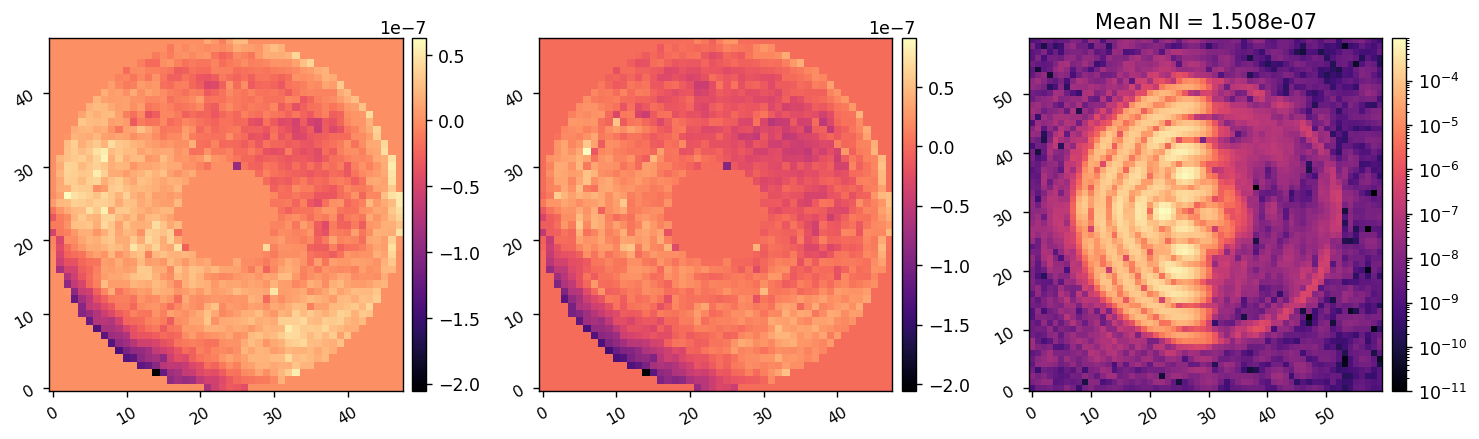

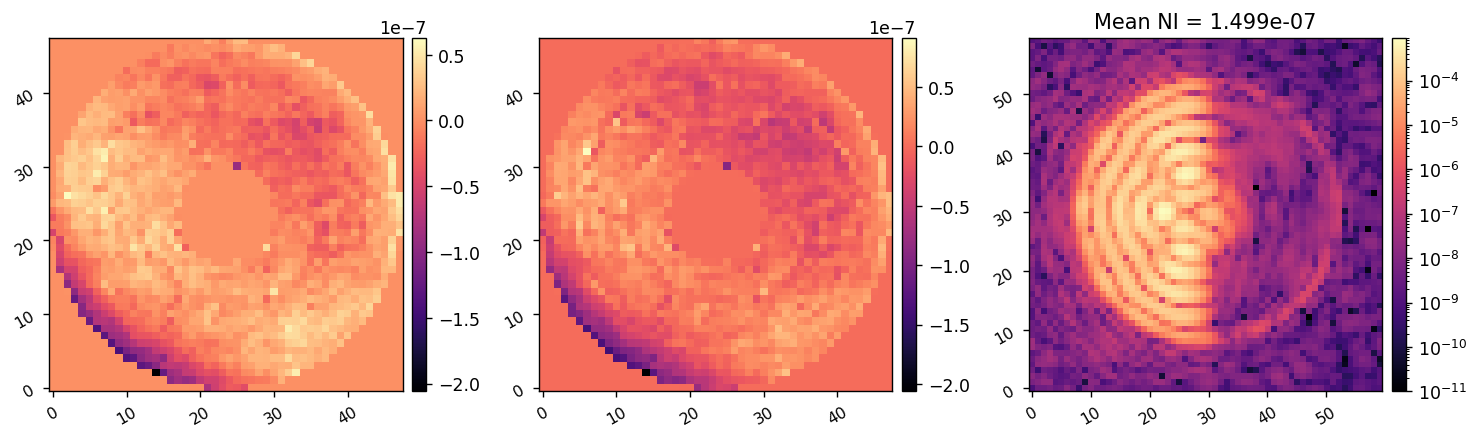

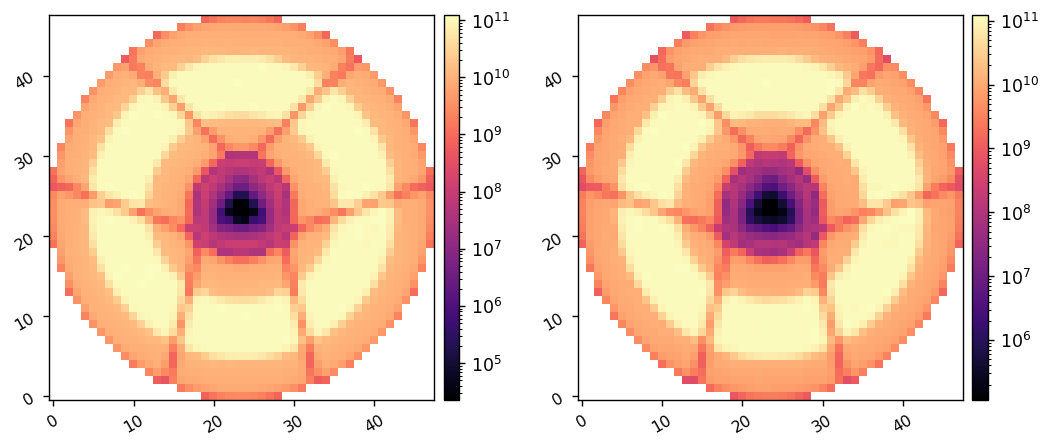

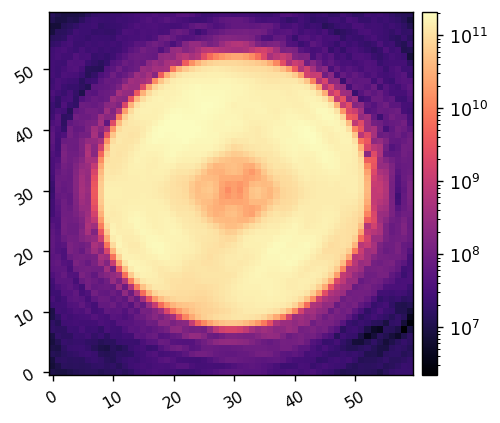

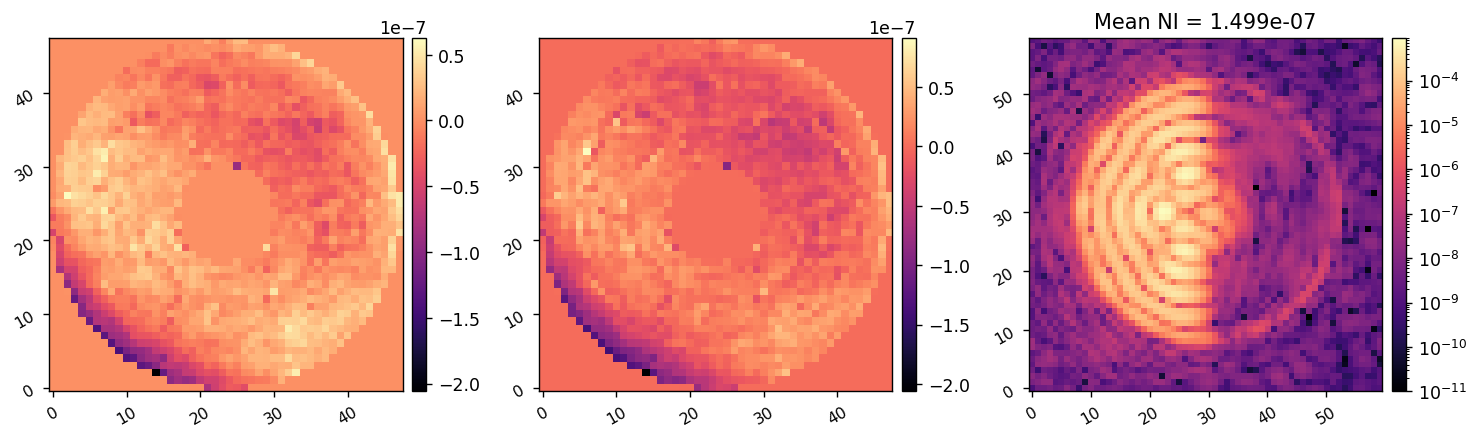

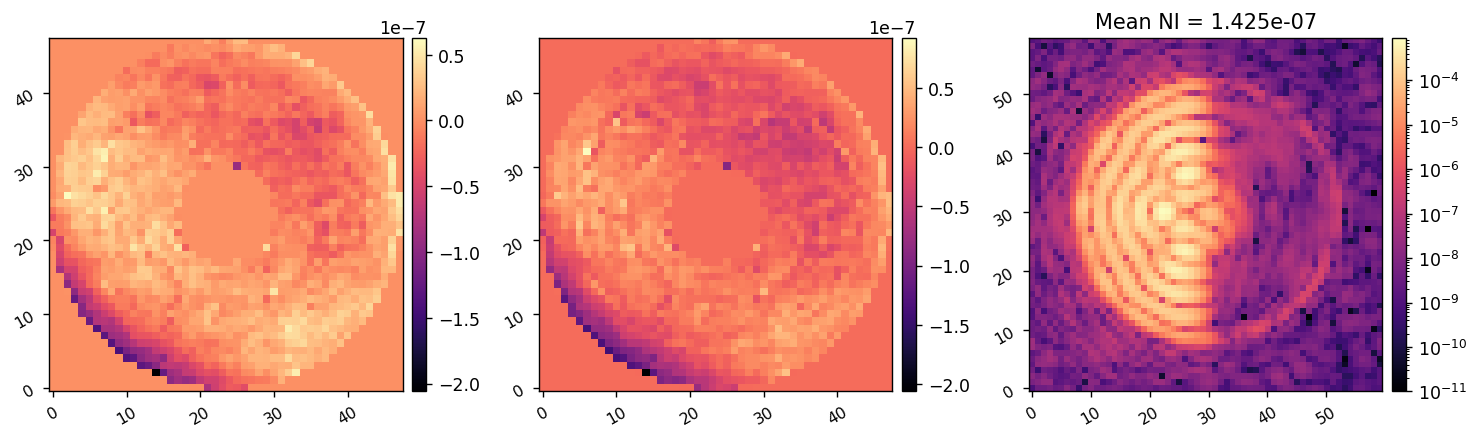

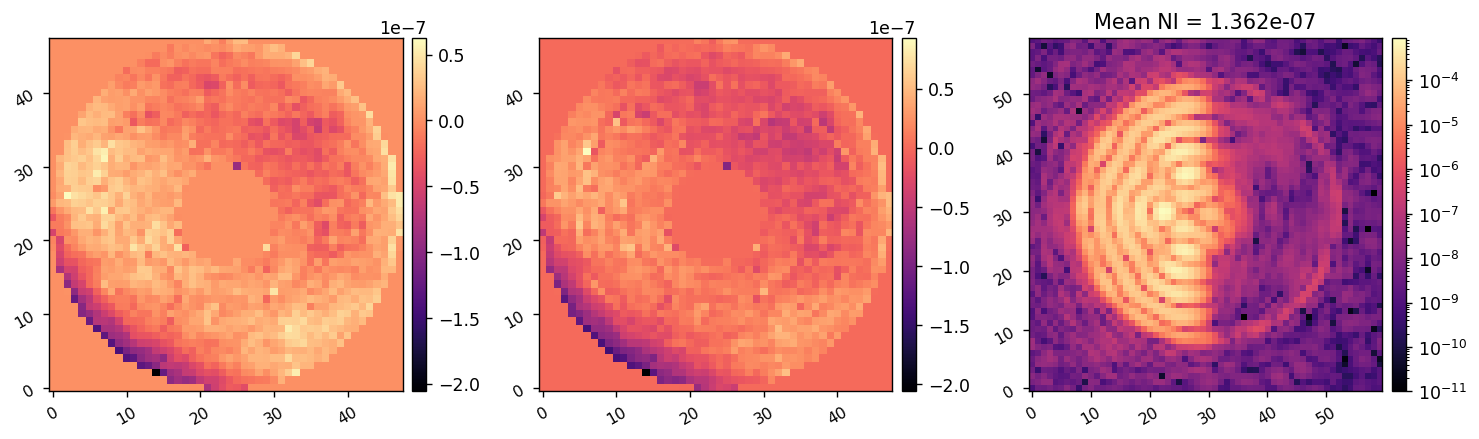

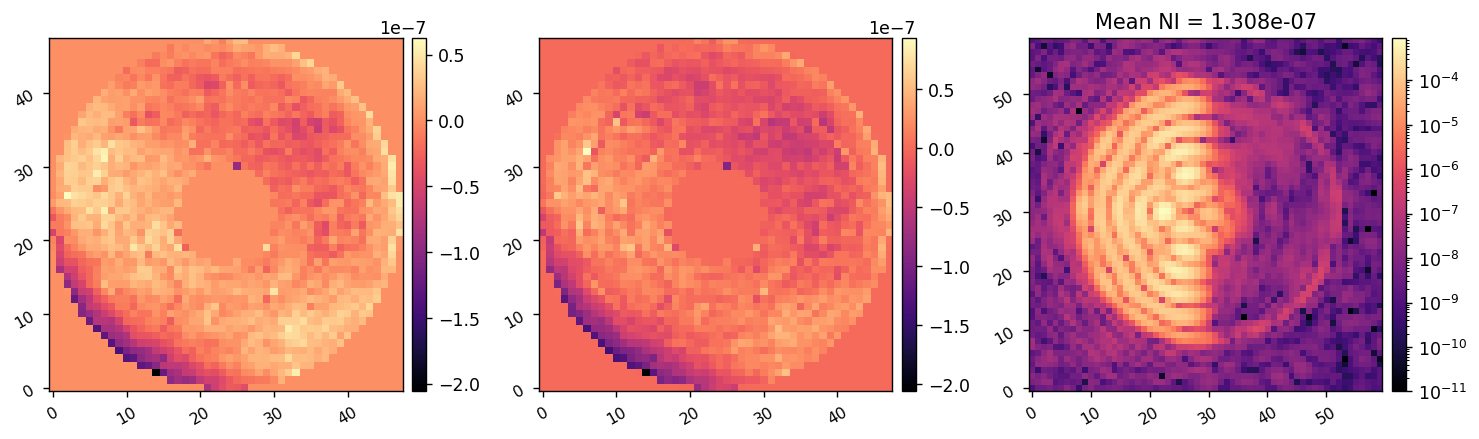

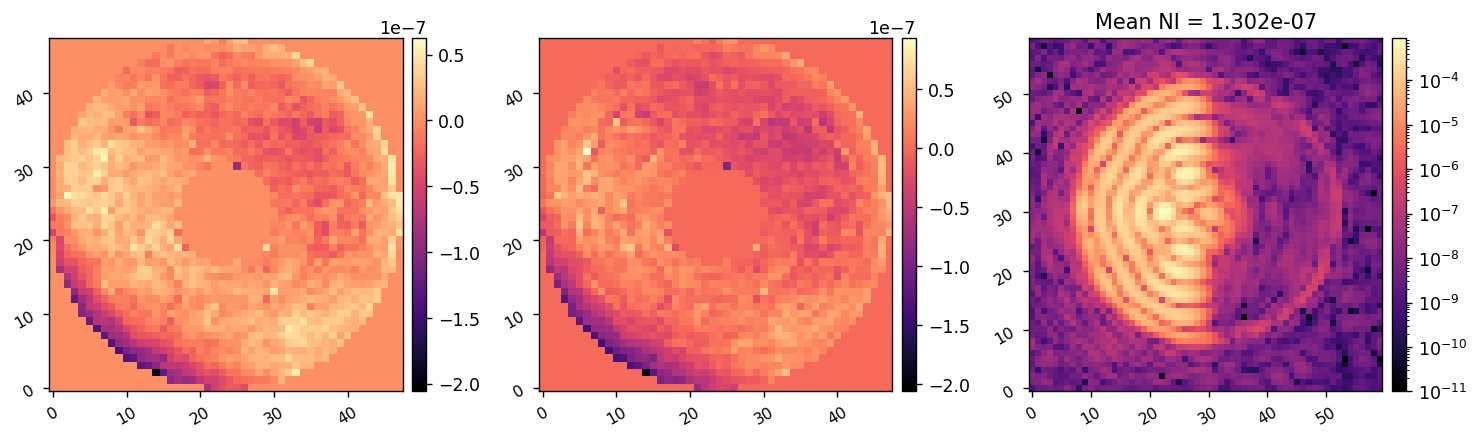

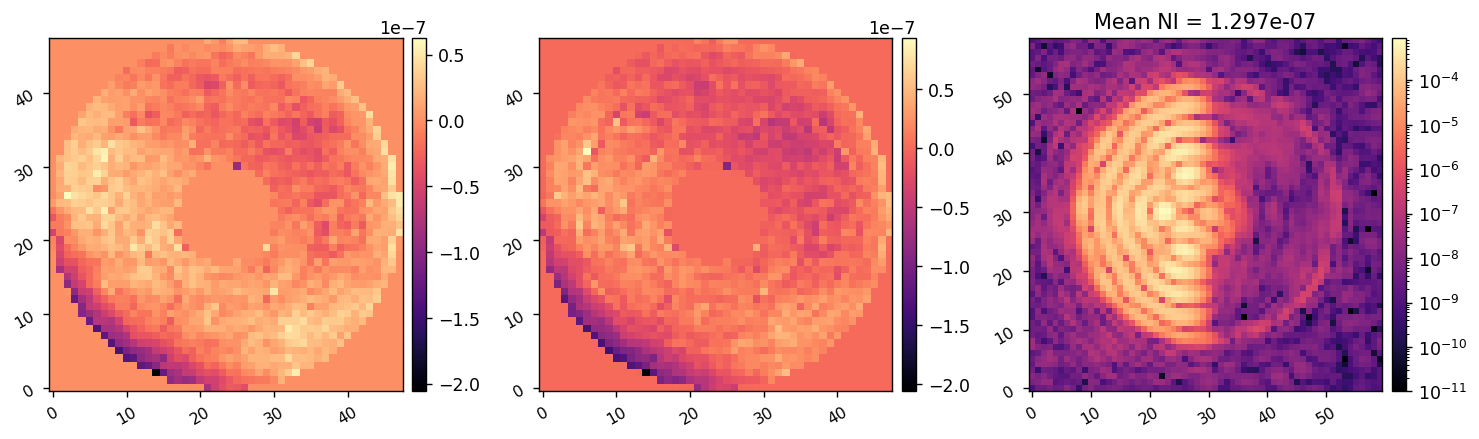

In [4]:
Ncalibs = 6
date = 20230801
# date = 20230801
for i in range(Ncalibs):
    response_matrix = xp.array(fits.getdata(response_dir/f'hlc_iefc_2dm_response_matrix_{i+1}_{Ncalibs}_{date}.fits'))
    response_cube = xp.array(fits.getdata(response_dir/f'hlc_iefc_2dm_response_cube_{i+1}_{Ncalibs}_{date}.fits'))
    dm1_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,:mode.Nacts]**2, axis=0)), mode.dm_mask)
    dm2_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,mode.Nacts:]**2, axis=0)), mode.dm_mask)
    imshow2(dm1_response , dm2_response, lognorm=True)

    fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(mode.npsf, mode.npsf)
    imshow1(fp_response, lognorm=True)
    
    images = xp.array(fits.getdata(data_dir/'images'/f'hlc_iefc_2dm_images_{i+1}_{Ncalibs}_{date}.fits'))
    dm1_commands = xp.array(fits.getdata(data_dir/'dm-commands'/f'hlc_iefc_2dm_dm1_{i+1}_{Ncalibs}_{date}.fits'))
    dm2_commands = xp.array(fits.getdata(data_dir/'dm-commands'/f'hlc_iefc_2dm_dm2_{i+1}_{Ncalibs}_{date}.fits'))
    
    for j in range(len(images)):
        mean_ni = xp.mean(images[j][control_mask])
        imshow3(dm1_commands[j], dm2_commands[j], images[j], None, None, f'Mean NI = {mean_ni:.3e}', lognorm3=True, vmin3=1e-11)